# Cell-type identification using spike waveform duration

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

This notebook aims to identify unit cell-types (excitatory v. inhibitory) based on the duration of the average spike waveform. This notebook loads the results of notebooks/cell_type_id/spike_waveform.ipynb. The results of this notebook are save to "/data/waveforms/waveform_features_thresholded.csv".

## Set-up

### imports

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.stats import norm

In [ ]:
# custom imports
import sys
sys.path.append('../../allen_vc')
from paths import PATH_EXTERNAL

### settings

### functions

In [ ]:
def gaussian_function(xs, *params):
    """Gaussian fitting function.

    Parameters
    ----------
    xs : 1d array
        Input x-axis values.
    *params : float
        Parameters that define gaussian function.

    Returns
    -------
    ys : 1d array
        Output values for gaussian function.
    """

    ys = np.zeros_like(xs)

    for ii in range(0, len(params), 3):

        ctr, hgt, wid = params[ii:ii+3]

        ys = ys + hgt * np.exp(-(xs-ctr)**2 / (2*wid**2))

    return ys


### load data

In [ ]:
# load/save results
df = pd.read_csv(f'{PATH_EXTERNAL}/data/waveforms/all_units.csv')

## Main

In [ ]:
# print some stats on waveform duration
df['waveform_duration'].describe()

count    18168.000000
mean         0.569733
std          0.232885
min          0.027471
25%          0.425796
50%          0.590620
75%          0.686767
max          2.692127
Name: waveform_duration, dtype: float64

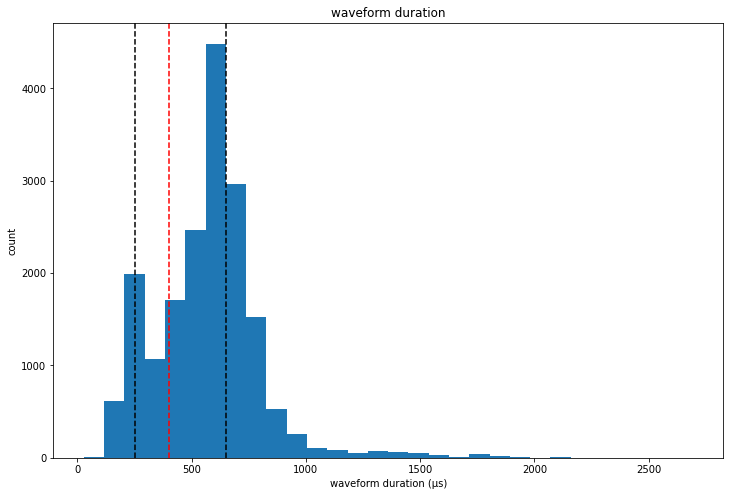

In [ ]:
# plot waveform duration
fig, ax = plt.subplots(1,1, figsize=[12,8])
ax.hist(df['waveform_duration']*1000, bins=30)
ax.set(xlabel="waveform duration (\u00B5s)", ylabel="count") # microseconds
ax.set_title("waveform duration")
ax.axvline(400, color='r', linestyle='--') # Irene's reccomended threshold
ax.axvline(250, color='k', linestyle='--') # highest peak from visual inspection
ax.axvline(650, color='k', linestyle='--') # second highest peak from visual inspection
plt.show()

95% confidence interval for first gaussian: (124.46527313496313, 391.8362038591249)
95% confidence interval for second gaussian: (381.1169423521628, 846.973580048256)


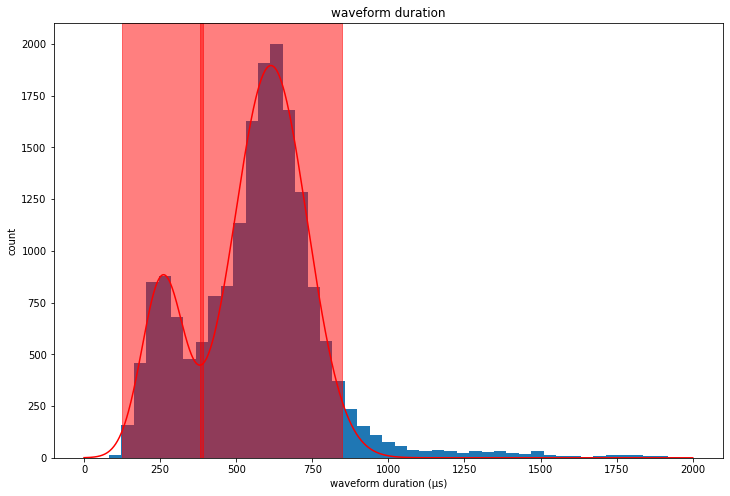

In [ ]:
# curve fit multiple gaussians to waveform duration
# we visually inspect the histogram and see that there are 2 peaks around 250 and 650 microseconds
# this will serve as our initial guess for the gaussian parameters
# we then compute the 95% confidence interval for each gaussian

# compute histogram of waveform duration
bin_edges = np.linspace(0, 2000, 50)
hist, bin_edges = np.histogram(df['waveform_duration']*1000, bins=bin_edges)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# fit gaussian
guess_params = [250, 600, 50, 650, 1300, 50]
xs = np.linspace(0, 2000, 1000)
fit_params, pcov = curve_fit(gaussian_function, bin_centers, hist, p0=guess_params)
ys = gaussian_function(xs, *fit_params)

# compute confidence interval range for both gaussians
interval_fs = norm.interval(0.95, loc=fit_params[0], scale=fit_params[2])
interval_ss = norm.interval(0.95, loc=fit_params[3], scale=fit_params[5])
print(f"95% confidence interval for first gaussian: {interval_fs}")
print(f"95% confidence interval for second gaussian: {interval_ss}")

# plot histogram and gaussian fit
fig, ax = plt.subplots(1,1, figsize=[12,8])
ax.hist(df['waveform_duration']*1000, bins=bin_edges)
ax.plot(xs, ys, color='r')
ax.set(xlabel="waveform duration (\u00B5s)", ylabel="count") # microseconds
ax.set_title("waveform duration")

# shade confidence intervals
ax.axvspan(interval_fs[0], interval_fs[1], alpha=0.5, color='r')
ax.axvspan(interval_ss[0], interval_ss[1], alpha=0.5, color='r')

plt.show()

trough between gaussians: 380.3803803803804


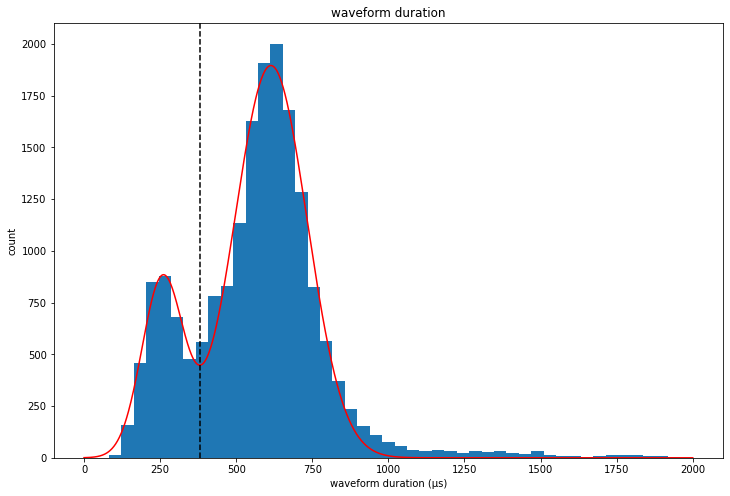

In [ ]:
# find trough between gaussians
# because the 95% confidence intervals overlap, we can use the trough between the two gaussians as a single threshold

# find trough between gaussians
ys_intermediate = ys[(xs > fit_params[0]) & (xs < fit_params[3])]
xs_intermediate = xs[(xs > fit_params[0]) & (xs < fit_params[3])]
trough = xs_intermediate[np.argmin(ys_intermediate)]
print(f"trough between gaussians: {trough}")

# plot histogram and gaussian fit
fig, ax = plt.subplots(1,1, figsize=[12,8])
ax.hist(df['waveform_duration']*1000, bins=bin_edges)
ax.plot(xs, ys, color='r')
ax.set(xlabel="waveform duration (\u00B5s)", ylabel="count") # microseconds
ax.set_title("waveform duration")
ax.axvline(trough, color='k', linestyle='--') # trough between gaussians
plt.show()

In [ ]:
# Apply duration threshold and save results 

# set threshold for duration_above (ms)
threshold = 0.38

df['duration_above'] = df['waveform_duration'] > threshold
df.to_csv(f'{PATH_EXTERNAL}/data/waveforms/waveform_features_thresholded.csv', index=False)